In [1]:
# Install the Prophet
!pip install prophet

In [2]:
# Import the required libraries and dependencies
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from prophet import Prophet

In [3]:
import warnings
# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# Set crypto variable
crypto = 'SHIB'

# Create crypto df
crypto_df = f'{crypto}_df'.lower()

In [5]:
# Store the crypto data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.
crypto_df = pd.read_csv(
    f'~/crypto-forecast/resources/{crypto}-USD.csv',
    index_col='Date',
    parse_dates=True
).dropna()

# Sort by ascending date
crypto_df = crypto_df.sort_values(by="Date", ascending=True)

# Review the first and last five rows of the DataFrame
display(crypto_df.head())
display(crypto_df.tail())

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-08-01,0.0,0.0,0.0,0.0,0.0,1604789
2020-08-02,0.0,0.0,0.0,0.0,0.0,193098
2020-08-03,0.0,0.0,0.0,0.0,0.0,129225
2020-08-04,0.0,0.0,0.0,0.0,0.0,19717
2020-08-05,0.0,0.0,0.0,0.0,0.0,26869


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-15,0.000023,0.000025,0.000023,0.000025,0.000025,1044394707
2024-05-16,0.000025,0.000026,0.000024,0.000025,0.000025,831016972
2024-05-17,0.000025,0.000025,0.000024,0.000025,0.000025,501636186
2024-05-18,0.000025,0.000025,0.000024,0.000025,0.000025,334996491
2024-05-19,0.000025,0.000025,0.000024,0.000024,0.000024,344502582


In [6]:
# Get last closing price
last_close_df = crypto_df.iloc[-1]
last_close_price = last_close_df['Close']
last_close_price

2.4e-05

In [7]:
crypto_df.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.990211,0.994075,0.987961,0.987961,0.538745
High,0.990211,1.000000,0.985643,0.995799,0.995799,0.626828
Low,0.994075,0.985643,1.000000,0.990878,0.990878,0.503858
Close,0.987961,0.995799,0.990878,1.000000,1.000000,0.590366
Adj Close,0.987961,0.995799,0.990878,1.000000,1.000000,0.590366
Volume,0.538745,0.626828,0.503858,0.590366,0.590366,1.000000


In [8]:
# Create new df with just Close prices and Volume
df_close = crypto_df[['Close', 'Volume']]

In [9]:
df_close.name = 'Close'
df_close

,Close,Volume
Date,,
2020-08-01,0.000000,1604789
2020-08-02,0.000000,193098
2020-08-03,0.000000,129225
2020-08-04,0.000000,19717
2020-08-05,0.000000,26869
...,...,...
2024-05-15,0.000025,1044394707
2024-05-16,0.000025,831016972
2024-05-17,0.000025,501636186


In [10]:
# Create a copy of the DataFrame to avoid the SettingWithCopyWarning
df_close_ma = df_close.copy()

# Calculate 10-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA10'] = df_close_ma['Close'].rolling(10).mean()

# Calculate 30-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA30'] = df_close_ma['Close'].rolling(30).mean()

# Calculate 50-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA50'] = df_close_ma['Close'].rolling(50).mean()

# Remove NULL values
df_close_ma.dropna(inplace=True)

In [11]:
# Review the first and last five rows of the DataFrame
display(df_close_ma.head())
display(df_close_ma.tail())

,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2020-09-19,0.0,3568,0.0,0.0,0.0
2020-09-20,0.0,2796,0.0,0.0,0.0
2020-09-21,0.0,1881,0.0,0.0,0.0
2020-09-22,0.0,468,0.0,0.0,0.0
2020-09-23,0.0,505,0.0,0.0,0.0


,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2024-05-15,0.000025,1044394707,0.000023,0.000024,0.000025
2024-05-16,0.000025,831016972,0.000023,0.000024,0.000025
2024-05-17,0.000025,501636186,0.000023,0.000024,0.000025
2024-05-18,0.000025,334996491,0.000023,0.000024,0.000025
2024-05-19,0.000024,344502582,0.000024,0.000024,0.000025


<Axes: xlabel='Date'>

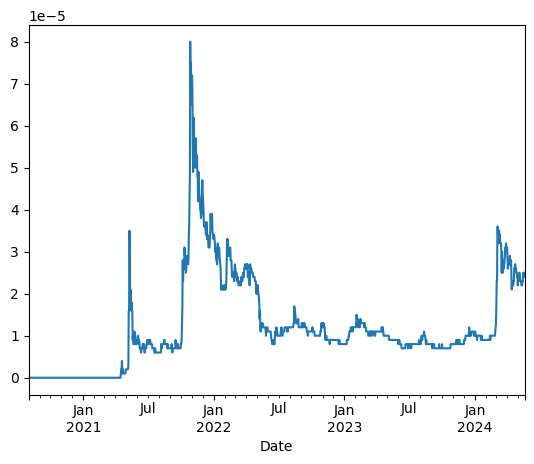

In [12]:
# Plot Close
df_close['Close'].plot()

In [13]:
## Create a Time Series Model with Prophet

In [14]:
# Using the DataFrame, reset the index so the date information is no longer the index
df_close = df_close.reset_index()

In [15]:
# Label the columns ds and y so that the syntax is recognized by Prophet
df_close.rename(columns={'Date':'ds','Close':'y'}, inplace=True)

# Drop an NaN values from the prophet_df DataFrame
df_close.dropna()

# View the first and last five rows of the DataFrame
df_close

,ds,y,Volume
0,2020-08-01,0.000000,1604789
1,2020-08-02,0.000000,193098
2,2020-08-03,0.000000,129225
3,2020-08-04,0.000000,19717
4,2020-08-05,0.000000,26869
...,...,...,...
1383,2024-05-15,0.000025,1044394707
1384,2024-05-16,0.000025,831016972
1385,2024-05-17,0.000025,501636186
1386,2024-05-18,0.000025,334996491


In [16]:
# Call the Prophet function, store as an object
crypto_model = Prophet()

In [17]:
# Fit the time-series model.
crypto_model.fit(df_close)

18:06:13 - cmdstanpy - INFO - Chain [1] start processing
18:06:13 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Create a future dataframe to hold predictions
# Make the prediction go out 30 days
crypto_future = crypto_model.make_future_dataframe(periods = 90, freq = 'd')

# View the last five rows of the DataFrame
crypto_future.tail(5)

,ds
1473,2024-08-13
1474,2024-08-14
1475,2024-08-15
1476,2024-08-16
1477,2024-08-17


In [19]:
# Make the predictions for the data using the DataFrame
crypto_forecast = crypto_model.predict(crypto_future)

# Display the first five rows of the DataFrame
crypto_forecast.tail(30)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1448,2024-07-19,0.000024,0.000016,0.000029,0.000022,0.000025,-1.521002e-06,-1.521002e-06,-1.521002e-06,-1.291673e-07,-1.291673e-07,-1.291673e-07,-0.000001,-0.000001,-0.000001,0.0,0.0,0.0,0.000022
1449,2024-07-20,0.000024,0.000016,0.000029,0.000022,0.000025,-1.518399e-06,-1.518399e-06,-1.518399e-06,-5.011328e-08,-5.011328e-08,-5.011328e-08,-0.000001,-0.000001,-0.000001,0.0,0.0,0.0,0.000022
1450,2024-07-21,0.000024,0.000015,0.000029,0.000022,0.000025,-1.523481e-06,-1.523481e-06,-1.523481e-06,1.350019e-08,1.350019e-08,1.350019e-08,-0.000002,-0.000002,-0.000002,0.0,0.0,0.0,0.000022
1451,2024-07-22,0.000024,0.000015,0.000029,0.000022,0.000025,-1.456178e-06,-1.456178e-06,-1.456178e-06,1.403600e-07,1.403600e-07,1.403600e-07,-0.000002,-0.000002,-0.000002,0.0,0.0,0.0,0.000022
1452,2024-07-23,0.000024,0.000015,0.000029,0.000022,0.000025,-1.573004e-06,-1.573004e-06,-1.573004e-06,7.280715e-08,7.280715e-08,7.280715e-08,-0.000002,-0.000002,-0.000002,0.0,0.0,0.0,0.000022
1453,2024-07-24,0.000024,0.000015,0.000029,0.000022,0.000026,-1.603098e-06,-1.603098e-06,-1.603098e-06,8.082254e-08,8.082254e-08,8.082254e-08,-0.000002,-0.000002,-0.000002,0.0,0.0,0.0,0.000022
1454,2024-07-25,0.000024,0.000015,0.000029,0.000022,0.000026,-1.838482e-06,-1.838482e-06,-1.838482e-06,-1.282093e-07,-1.282093e-07,-1.282093e-07,-0.000002,-0.000002,-0.000002,0.0,0.0,0.0,0.000022
1455,2024-07-26,0.000024,0.000015,0.000029,0.000022,0.000026,-1.853751e-06,-1.853751e-06,-1.853751e-06,-1.291673e-07,-1.291673e-07,-1.291673e-07,-0.000002,-0.000002,-0.000002,0.0,0.0,0.0,0.000022
1456,2024-07-27,0.000024,0.000015,0.000029,0.000022,0.000026,-1.776991e-06,-1.776991e-06,-1.776991e-06,-5.011328e-08,-5.011328e-08,-5.011328e-08,-0.000002,-0.000002,-0.000002,0.0,0.0,0.0,0.000022
1457,2024-07-28,0.000024,0.000015,0.000029,0.000022,0.000026,-1.703998e-06,-1.703998e-06,-1.703998e-06,1.350019e-08,1.350019e-08,1.350019e-08,-0.000002,-0.000002,-0.000002,0.0,0.0,0.0,0.000022


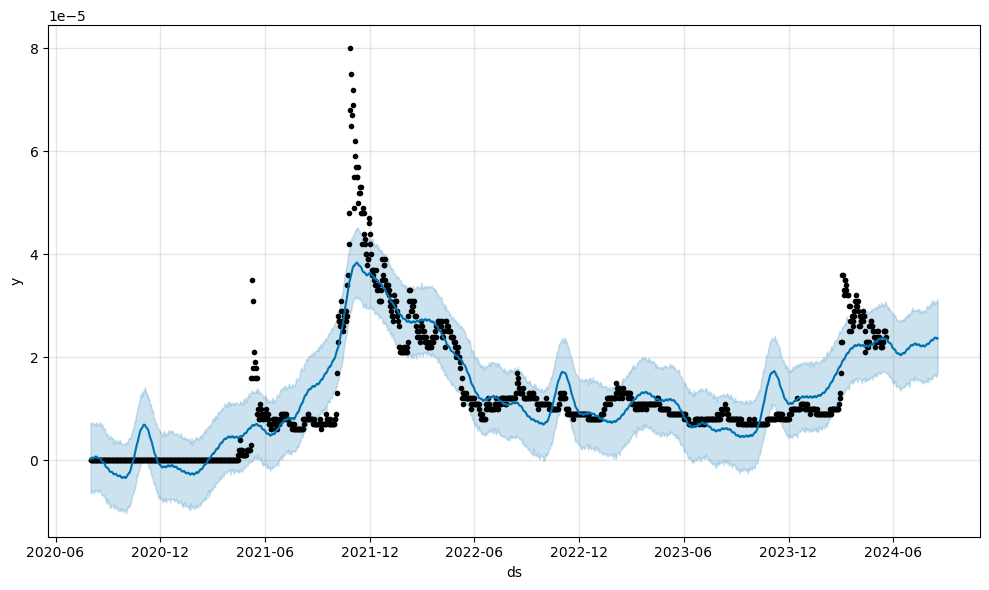

In [20]:
# Plot the Prophet predictions for the data
crypto_model.plot(crypto_forecast)
plt.savefig(f'{crypto}_forecast', bbox_inches = 'tight')

In [21]:
# Set the index in the forecast DataFrame to the ds datetime column
crypto_forecast = crypto_forecast.set_index('ds')

In [22]:
# View only the yhat,yhat_lower and yhat_upper columns from the forecast DataFrame
crypto_forecast[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-90:,:]

,yhat,yhat_lower,yhat_upper
ds,,,
2024-05-20,0.000024,0.000017,0.000030
2024-05-21,0.000023,0.000017,0.000030
2024-05-22,0.000023,0.000017,0.000030
2024-05-23,0.000023,0.000017,0.000029
2024-05-24,0.000023,0.000016,0.000030
...,...,...,...
2024-08-13,0.000024,0.000016,0.000030
2024-08-14,0.000024,0.000016,0.000031
2024-08-15,0.000024,0.000016,0.000031


In [23]:
# Rename columns
crypto_forecast.rename(columns={'yhat':'mid trend price','yhat_lower':'lower trend price','yhat_upper':'upper trend price'}, inplace=True)

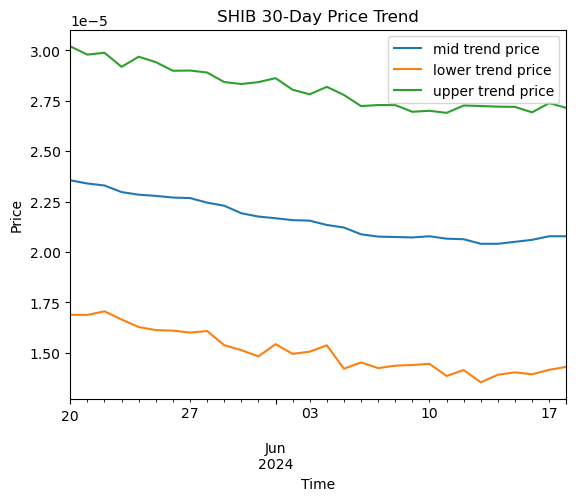

In [24]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-60,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 30-Day Price Trend')    
plt.show()

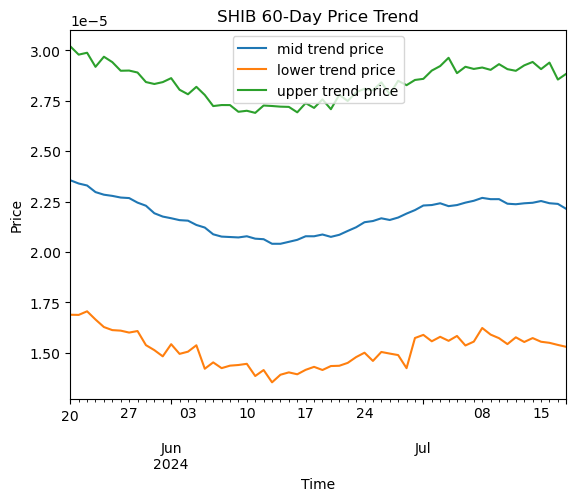

In [25]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-30,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 60-Day Price Trend')    
plt.show()

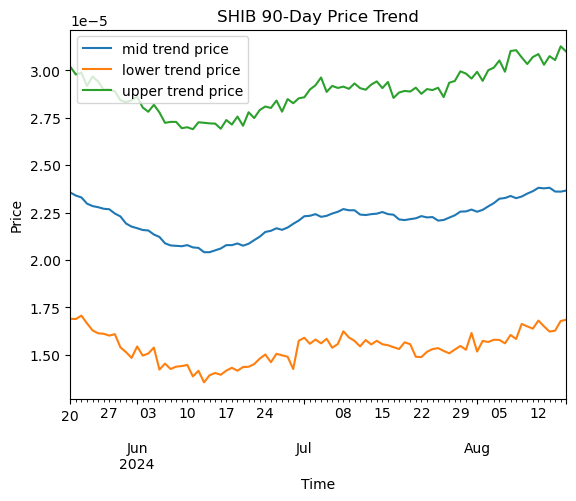

In [26]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 90-Day Price Trend')    
plt.savefig(f'{crypto}_90d_trend_forecast', bbox_inches = 'tight')
plt.show()

In [27]:
# Retrieve last closing price
last_close_price

2.4e-05

In [28]:
# Retreive tomorrow's mid trend price forecast
tommorow_mid_trend_price = crypto_forecast['mid trend price'].iloc[-90]
tommorow_mid_trend_price

2.355683483799812e-05

In [29]:
# Calculate tommorrow's weighted price
wp = last_close_price*.5 + tommorow_mid_trend_price*.5
wp

2.377841741899906e-05

In [30]:
# Retreive tomorrow's weighted trend price forecast
tommorow_mid_trend_price = ((crypto_forecast['mid trend price'].iloc[-90]*.6)+(crypto_forecast['upper trend price'].iloc[-90]*.2)+(crypto_forecast['lower trend price'].iloc[-90]*.2))
tommorow_mid_trend_price

2.3551240747104437e-05

In [31]:
# Retrieve weighted trend price in 30 days
mid_trend_price_in_30 = ((crypto_forecast['mid trend price'].iloc[-60]*.6)+(crypto_forecast['upper trend price'].iloc[-60]*.2)+(crypto_forecast['lower trend price'].iloc[-60]*.2))
mid_trend_price_in_30

2.086453385734974e-05

In [32]:
# Retrieve weighted trend price in 60 days
mid_trend_price_in_60 = ((crypto_forecast['mid trend price'].iloc[-30]*.6)+(crypto_forecast['upper trend price'].iloc[-30]*.2)+(crypto_forecast['lower trend price'].iloc[-30]*.2))
mid_trend_price_in_60

2.217501367979307e-05

In [33]:
# Retrieve weighted trend price in 90 days
mid_trend_price_in_90 = ((crypto_forecast['mid trend price'].iloc[-1]*.6)+(crypto_forecast['upper trend price'].iloc[-1]*.2)+(crypto_forecast['lower trend price'].iloc[-1]*.2))
mid_trend_price_in_90

2.376293484921288e-05

In [34]:
# Calculate expected gain/loss between mid trend price in 30 days and last close price
#percent_diff_30 = ((mid_trend_price_in_30)/(last_close_price))-1
percent_diff_30 = ((mid_trend_price_in_30)/(wp))-1
percent_diff_30.round(3)

-0.123

In [35]:
# Calculate expected gain/loss between mid trend price in 60 days and last close price
#percent_diff_60 = ((mid_trend_price_in_60)/(last_close_price))-1
percent_diff_60 = ((mid_trend_price_in_60)/(wp))-1
percent_diff_60.round(3)

-0.067

In [36]:
# Calculate expected gain/loss between mid trend price in 90 days and last close price
#percent_diff_90 = ((mid_trend_price_in_90)/(last_close_price))-1
percent_diff_90 = ((mid_trend_price_in_90)/(wp))-1
percent_diff_90.round(3)

-0.001

In [37]:
# Reset the index in the forecast DataFrame
crypto_forecast = crypto_forecast.reset_index()

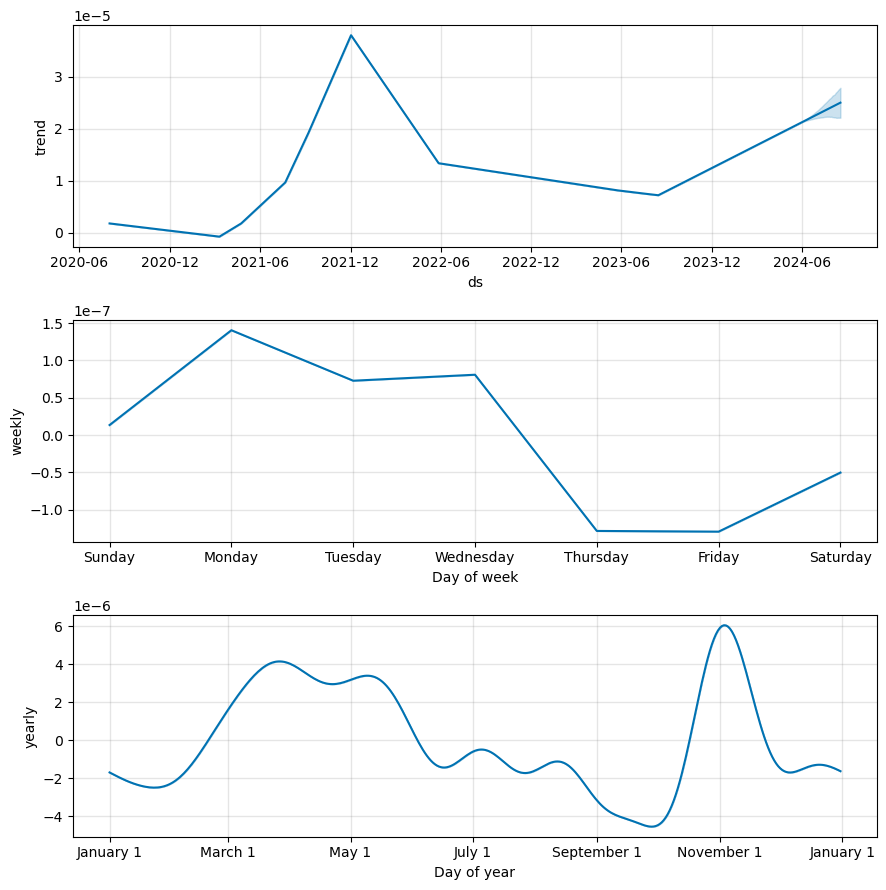

In [38]:
# Use the plot_components function to visualize the forecast results
# for the forecast DataFrame
fig_comp = crypto_model.plot_components(crypto_forecast)
plt.savefig(f'{crypto}_components.png', bbox_inches = 'tight')

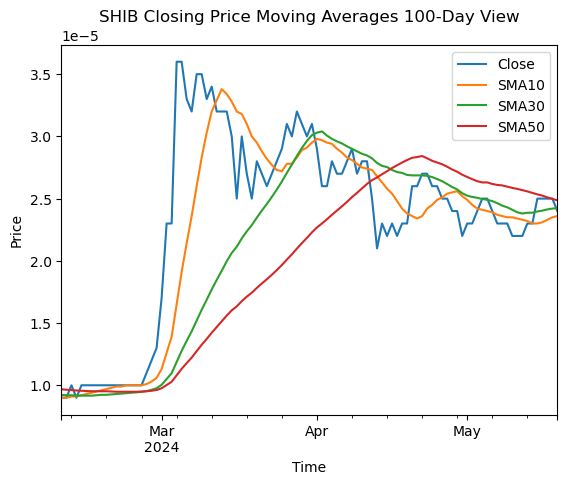

In [39]:
df_last_100 = df_close_ma.iloc[-100:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 100-Day View')    
plt.show()

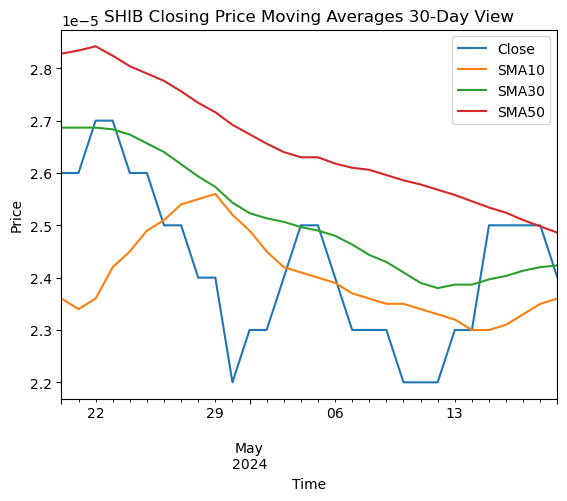

In [40]:
df_last_100 = df_close_ma.iloc[-30:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 30-Day View')    
plt.savefig(f'{crypto}_30d_MA_view.png', bbox_inches = 'tight')
plt.show()

In [41]:
# import module
from datetime import datetime
 
# get current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d")
print("Current date & time : ", current_datetime)
 
# convert datetime obj to string
str_current_datetime = str(current_datetime)
 
# create a file object along with extension
#file_name = f'{crypto} '+str_current_datetime+".txt"
file_name = str_current_datetime+".csv"
file = open(file_name, 'a')
 
print("File created : ", file.name)
file.close()

Current date & time :  2024-05-20
File created :  2024-05-20.csv


In [42]:
f = open(f'{file_name}', "a")
f.writelines([f'{crypto},{last_close_price},{percent_diff_30},{percent_diff_60},{percent_diff_90}\n'])
f.close()

In [43]:
f = open(f'{file_name}', "r")
print(f.read())

ADA,0.467602,0.016141654551261597,-0.048511607018260405,0.26698037580557354
BNB,574.63,-0.3370363083405419,-0.3290568236386213,-0.2790790471601129
BONK,2.5e-05,0.25779530706847753,0.4080859075709553,0.5429258111537147
BTC,66278.37,-0.2191180233361938,-0.1951255528263407,-0.16020045358030566
DOGE,0.149107,-0.22857973922643027,-0.28954294972299366,-0.13383869168157447
ETH,3094.12,-0.05566025624110993,-0.04356552970504457,0.046438254274701274
PEPE,9e-06,0.3163098292378519,0.5695209080409678,0.79019064181281
SHIB,2.4e-05,-0.13447450951251372,-0.07783705937680974,-0.018044767636294923
SOL,170.09,0.02993653747852032,0.09897686371903935,0.15883864333841902
XRP,0.509661,0.08170842018061886,0.1175389631277377,0.251808862234169
ADA,0.467602,-0.05356931769426376,-0.12050457682285454,0.1829944797779357
ADA,0.467602,-0.07589607234414741,-0.135242805763105,0.15993249027663747
BNB,574.63,-0.23839504335644301,-0.2336482812093087,-0.1748296149590688
BONK,2.5e-05,0.1887956631518306,0.32592832450639286,0